# Run STitch3D on the adult mouse brain dataset

In this tutorial, we show STitch3D's analysis of the adult mouse brain dataset.

The spatial transcriptomics mouse brain data are publicly available at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE147747. The mouse brain dataset profiled by 10x Genomics Chromium platform is available at https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-11115.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import os
import sys

import STitch3D

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Preprocessing

### Load datasets

Load spatial transcriptomics datasets:

In [2]:
count = pd.read_csv("./data/GSE147747_expr_raw_counts_table.tsv",
                    sep="\t", index_col=0)

meta = pd.read_csv("./data/GSE147747_meta_table.tsv",
                   sep="\t", index_col=0)

adata_st_all = ad.AnnData(X = count.values)
adata_st_all.obs.index = count.index
adata_st_all.obs = meta.loc[adata_st_all.obs.index]
adata_st_all.var.index = count.columns

slice_use = ['01A', '02A', '03A', '04B', '05A', '06B', '07A', '08B', '09A', '10B',
 '11A', '12A', '13B', '14A', '15A', '16A', '17A', '18A', '19A', '20B',
 '21A', '22A', '23A', '24A', '25A', '26A', '27A', '28A', '29A', '30A',
 '31A', '32A', '33A', '34A', '35A',]

meta_slice = pd.read_csv("./data/molecular-atlas-master/data/slicestable.tsv",
                        index_col=0, sep="\t")
slice_AP = [float(meta_slice.loc[s]['AP']) * 1000 for s in slice_use]
slice_dist_micron = [-(slice_AP[i+1] - slice_AP[i]) for i in range(len(slice_AP)-1)]

adata_st_all = adata_st_all[[s in slice_use for s in adata_st_all.obs.section_index.values]]
sc.pp.filter_cells(adata_st_all, min_genes=1)

adata_st_all.obsm['spatial'] = np.concatenate((adata_st_all.obs['HE_X'].values.reshape(-1, 1),
                                               adata_st_all.obs['HE_Y'].values.reshape(-1, 1)), axis=1)

adata_st_list_raw = []

for slice_id in sorted(set(adata_st_all.obs.section_index.values)):
    adata_st_i = adata_st_all[adata_st_all.obs.section_index.values == slice_id]
    
    array_col = np.array([np.float(loc.split("_")[1].split("x")[0]) for loc in adata_st_i.obs.index])
    if slice_id == '01A':
        array_col = array_col - 0.3
    array_row = np.array([np.float(loc.split("_")[1].split("x")[1]) for loc in adata_st_i.obs.index])
    
    adata_st_i.obs['array_col'] = np.round(array_col)
    adata_st_i.obs['array_row'] = np.round(array_row)
    adata_st_i.obsm['loc_use'] = np.concatenate((adata_st_i.obs['array_row'].values.reshape(-1, 1),
                                                 adata_st_i.obs['array_col'].values.reshape(-1, 1)), axis=1)

    adata_st_list_raw.append(adata_st_i.copy())

for i in range(1, 6): # adjust spatial locations
    adata_st_list_raw[i].obsm['loc_use'] = np.concatenate((adata_st_list_raw[i].obsm['loc_use'][:, 0].reshape(-1, 1),
                                                           2*np.mean(adata_st_list_raw[i].obsm['loc_use'][:, 1])-adata_st_list_raw[i].obsm['loc_use'][:, 1].reshape(-1, 1)), axis=1)

Load single-cell reference dataset:

In [3]:
adata_ref = ad.read_h5ad("./data/MouseBrain/all_cells_20200625.h5ad")
adata_ref.var.index = adata_ref.var["SYMBOL"].astype(str)
adata_ref.var_names_make_unique()
labels = pd.read_csv("./data/MouseBrain/snRNA_annotation_astro_subtypes_refined59_20200823.csv", index_col=0)

labels = labels.reindex(index=adata_ref.obs_names)
adata_ref.obs[labels.columns] = labels
adata_ref = adata_ref[~adata_ref.obs['annotation_1'].isna(), :]
adata_ref.obs['celltype'] = adata_ref.obs['annotation_1']

### Alignment of ST tissue slices

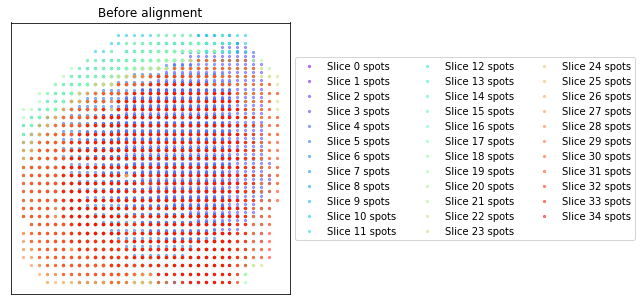

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


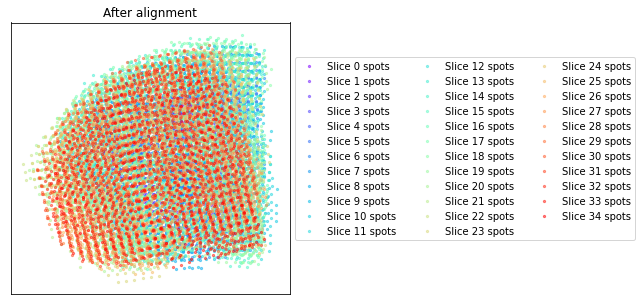

In [4]:
adata_st_list = STitch3D.utils.align_spots(adata_st_list_raw, 
                                           data_type = "ST", 
                                           coor_key="loc_use", 
                                           plot=True)

### Selecting highly variable genes and building 3D spatial graph

In [5]:
adata_st, adata_basis = STitch3D.utils.preprocess(adata_st_list, 
                                                  adata_ref, 
                                                  sample_col="sample",
                                                  coor_key="loc_use",
                                                  slice_dist_micron=slice_dist_micron,
                                                  c2c_dist=200.,
                                                  n_hvg_group=500)

Finding highly variable genes...
6227 highly variable genes selected.
Calculate basis for deconvolution...
6 batches are used for computing the basis vector of cell type <Astro_AMY>.
6 batches are used for computing the basis vector of cell type <Astro_AMY_CTX>.
6 batches are used for computing the basis vector of cell type <Astro_CTX>.
6 batches are used for computing the basis vector of cell type <Astro_HPC>.
6 batches are used for computing the basis vector of cell type <Astro_HYPO>.
4 batches are used for computing the basis vector of cell type <Astro_STR>.
5 batches are used for computing the basis vector of cell type <Astro_THAL_hab>.
6 batches are used for computing the basis vector of cell type <Astro_THAL_lat>.
6 batches are used for computing the basis vector of cell type <Astro_THAL_med>.
6 batches are used for computing the basis vector of cell type <Astro_WM>.
4 batches are used for computing the basis vector of cell type <Endo>.
6 batches are used for computing the basis 

## Running STitch3D model

In [6]:
model = STitch3D.model.Model(adata_st, adata_basis)

model.train()

  0%|          | 1/20000 [00:00<2:34:30,  2.16it/s]

Step: 0, Loss: 5119.6099, d_loss: 5114.2056, f_loss: 54.0438


 10%|█         | 2001/20000 [09:03<1:23:01,  3.61it/s]

Step: 2000, Loss: -1540.9728, d_loss: -1543.6028, f_loss: 26.3004


 20%|██        | 4001/20000 [18:06<1:13:40,  3.62it/s]

Step: 4000, Loss: -1753.4928, d_loss: -1756.0886, f_loss: 25.9588


 30%|███       | 6001/20000 [27:10<1:04:31,  3.62it/s]

Step: 6000, Loss: -1802.1528, d_loss: -1804.7277, f_loss: 25.7478


 40%|████      | 8001/20000 [36:13<55:30,  3.60it/s]  

Step: 8000, Loss: -1811.4734, d_loss: -1814.0398, f_loss: 25.6645


 50%|█████     | 10001/20000 [45:17<46:09,  3.61it/s]

Step: 10000, Loss: -1815.8132, d_loss: -1818.3693, f_loss: 25.5607


 60%|██████    | 12001/20000 [54:21<36:59,  3.60it/s]

Step: 12000, Loss: -1818.3048, d_loss: -1820.8562, f_loss: 25.5137


 70%|███████   | 14001/20000 [1:03:25<27:45,  3.60it/s]

Step: 14000, Loss: -1818.5482, d_loss: -1821.1080, f_loss: 25.5986


 80%|████████  | 16001/20000 [1:12:28<18:25,  3.62it/s]

Step: 16000, Loss: -1817.8567, d_loss: -1820.4270, f_loss: 25.7029


 90%|█████████ | 18001/20000 [1:21:31<09:14,  3.61it/s]

Step: 18000, Loss: -1824.0372, d_loss: -1826.5833, f_loss: 25.4606


100%|██████████| 20000/20000 [1:30:34<00:00,  3.68it/s]


In [7]:
save_path = "./results_mouse_brain"

result = model.eval(adata_st_list_raw, save=True, output_path=save_path)